## Logistic Regression Baseline (60/20/20 split)



In [ ]:

import pandas as pd
import numpy as np

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    balanced_accuracy_score,
    brier_score_loss,
)

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

RANDOM_STATE = 42
TOPK_RATIO = 0.1


### Step 1: Load Dataset

In [2]:
DATA_PATH = Path('churn_clean.csv')
df = pd.read_csv(DATA_PATH)
df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Step 2: Prepare Features and Target

In [3]:
X = df.drop('Exited', axis=1)
y = df['Exited']

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()
cat_cols, num_cols


(['Geography', 'Gender'],
 ['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'])

In [4]:

def topk_precision_recall(y_true, y_proba, k_ratio: float = TOPK_RATIO):
    """Compute Precision@K and Recall@K for binary predictions."""
    assert 0 < k_ratio <= 1, 'k_ratio must be in (0, 1].'
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)

    n = len(y_true)
    k = max(1, int(np.floor(n * k_ratio)))
    order = np.argsort(-y_proba)
    topk_idx = order[:k]

    y_topk = y_true[topk_idx]
    tp_at_k = y_topk.sum()
    total_pos = y_true.sum()

    precision_at_k = tp_at_k / k
    recall_at_k = tp_at_k / total_pos if total_pos > 0 else 0.0

    return {
        'K': k,
        'Precision@K': precision_at_k,
        'Recall@K': recall_at_k,
    }


def evaluate_classifier(y_true, y_proba, threshold: float = 0.5, k_ratio: float = TOPK_RATIO):
    """Return ROC-AUC, PR-AUC, F1, Balanced Accuracy, Brier Score, Precision@K/Recall@K."""
    y_true_arr = y_true.values if hasattr(y_true, 'values') else np.asarray(y_true)
    y_proba_arr = np.asarray(y_proba)
    y_pred = (y_proba_arr >= threshold).astype(int)

    metrics = {
        'ROC-AUC': roc_auc_score(y_true_arr, y_proba_arr),
        'PR-AUC': average_precision_score(y_true_arr, y_proba_arr),
        'F1': f1_score(y_true_arr, y_pred),
        'BalancedAccuracy': balanced_accuracy_score(y_true_arr, y_pred),
        'BrierScore': brier_score_loss(y_true_arr, y_proba_arr),
    }

    topk = topk_precision_recall(y_true_arr, y_proba_arr, k_ratio=k_ratio)
    metrics.update(topk)
    return metrics


In [5]:

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocess = ColumnTransformer([
    ('categorical', ohe, cat_cols),
    ('numeric', StandardScaler(), num_cols)
])

def build_log_reg_pipeline(penalty: str) -> Pipeline:
    solver = 'liblinear' if penalty in {'l1', 'l2'} else 'lbfgs'
    return Pipeline([
        ('preprocess', preprocess),
        ('model', LogisticRegression(
            penalty=penalty,
            solver=solver,
            max_iter=2000,
            class_weight='balanced',
            random_state=RANDOM_STATE,
        ))
    ])

penalties = ['l1', 'l2']
log_reg_models = {pen: build_log_reg_pipeline(pen) for pen in penalties}
log_reg_models


{'l1': Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('categorical',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_output=False),
                                                   ['Geography', 'Gender']),
                                                  ('numeric', StandardScaler(),
                                                   ['CreditScore', 'Age',
                                                    'Tenure', 'Balance',
                                                    'NumOfProducts', 'HasCrCard',
                                                    'IsActiveMember',
                                                    'EstimatedSalary'])])),
                 ('model',
                  LogisticRegression(class_weight='balanced', max_iter=2000,
                                     penalty='l1', random_state=42,
               

### Step 3: Train/Validation/Test Split (60/20/20)

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    stratify=y,
    random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print('Train:', X_train.shape, 'Target ratio:', y_train.mean().round(3))
print('Validation:', X_val.shape, 'Target ratio:', y_val.mean().round(3))
print('Test:', X_test.shape, 'Target ratio:', y_test.mean().round(3))


Train: (6000, 10) Target ratio: 0.204
Validation: (2000, 10) Target ratio: 0.204
Test: (2000, 10) Target ratio: 0.204


### Step 4: Build Pipeline

### Step 5: Train Model

In [7]:

for penalty, pipeline in log_reg_models.items():
    pipeline.fit(X_train, y_train)
    print(f'Trained LogReg-{penalty.upper()} model.')

log_reg_models


Trained LogReg-L1 model.
Trained LogReg-L2 model.


{'l1': Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('categorical',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_output=False),
                                                   ['Geography', 'Gender']),
                                                  ('numeric', StandardScaler(),
                                                   ['CreditScore', 'Age',
                                                    'Tenure', 'Balance',
                                                    'NumOfProducts', 'HasCrCard',
                                                    'IsActiveMember',
                                                    'EstimatedSalary'])])),
                 ('model',
                  LogisticRegression(class_weight='balanced', max_iter=2000,
                                     penalty='l1', random_state=42,
               

### Step 6: Evaluate on Validation and Test Sets

In [8]:

predictions = {}
dataset_labels = {'Validation': y_val, 'Test': y_test}

for penalty, pipeline in log_reg_models.items():
    predictions[penalty] = {}
    for dataset_name, y_true in dataset_labels.items():
        X_split = X_val if dataset_name == 'Validation' else X_test
        y_pred = pipeline.predict(X_split)
        y_proba = pipeline.predict_proba(X_split)[:, 1]
        predictions[penalty][dataset_name] = {
            'y_true': y_true,
            'y_pred': y_pred,
            'y_proba': y_proba,
        }

predictions


{'l1': {'Validation': {'y_true': 8583    0
   1924    0
   3195    0
   5263    0
   1484    0
          ..
   926     0
   6727    1
   4745    1
   1307    0
   7464    1
   Name: Exited, Length: 2000, dtype: int64,
   'y_pred': array([0, 0, 1, ..., 1, 1, 1], shape=(2000,)),
   'y_proba': array([0.40777181, 0.35131583, 0.51428195, ..., 0.79104322, 0.57175451,
          0.56888106], shape=(2000,))},
  'Test': {'y_true': 9167    0
   9387    0
   6859    0
   3500    0
   6233    0
          ..
   7392    0
   3233    0
   218     1
   4755    0
   7634    0
   Name: Exited, Length: 2000, dtype: int64,
   'y_pred': array([0, 0, 1, ..., 0, 0, 0], shape=(2000,)),
   'y_proba': array([0.19331757, 0.41808945, 0.57046802, ..., 0.48062928, 0.33736966,
          0.45401148], shape=(2000,))}},
 'l2': {'Validation': {'y_true': 8583    0
   1924    0
   3195    0
   5263    0
   1484    0
          ..
   926     0
   6727    1
   4745    1
   1307    0
   7464    1
   Name: Exited, Length: 2000,

In [9]:

metrics_records = []
model_labels = {'l1': 'LogReg-L1', 'l2': 'LogReg-L2'}
for penalty, dataset_dict in predictions.items():
    for dataset_name, values in dataset_dict.items():
        metrics = evaluate_classifier(values['y_true'], values['y_proba'], k_ratio=TOPK_RATIO)
        metrics_records.append({
            'Model': model_labels[penalty],
            'Dataset': dataset_name,
            **metrics,
        })

metrics_df = pd.DataFrame(metrics_records)
metrics_df


,Model,Dataset,ROC-AUC,PR-AUC,F1,BalancedAccuracy,BrierScore,K,Precision@K,Recall@K
0,LogReg-L1,Validation,0.793882,0.488882,0.519658,0.728705,0.194466,200,0.585,0.286765
1,LogReg-L1,Test,0.772754,0.478595,0.485885,0.698863,0.196437,200,0.540,0.265356
2,LogReg-L2,Validation,0.793859,0.489086,0.519658,0.728705,0.194385,200,0.585,0.286765
3,LogReg-L2,Test,0.772710,0.478686,0.485885,0.698863,0.196370,200,0.540,0.265356


In [10]:

conf_matrices = {}
for penalty in model_labels:
    conf_matrices[penalty] = {}
    for dataset_name in ['Validation', 'Test']:
        values = predictions[penalty][dataset_name]
        cm = confusion_matrix(values['y_true'], values['y_pred'])
        conf_matrices[penalty][dataset_name] = cm
        print(f"{model_labels[penalty]} - {dataset_name} classification report")
        print(classification_report(values['y_true'], values['y_pred']))

conf_matrices


LogReg-L1 - Validation classification report
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1592
           1       0.40      0.75      0.52       408

    accuracy                           0.72      2000
   macro avg       0.66      0.73      0.66      2000
weighted avg       0.81      0.72      0.74      2000

LogReg-L1 - Test classification report
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1593
           1       0.37      0.70      0.49       407

    accuracy                           0.70      2000
   macro avg       0.64      0.70      0.64      2000
weighted avg       0.79      0.70      0.73      2000

LogReg-L2 - Validation classification report
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1592
           1       0.40      0.75      0.52       408

    accuracy                           0.72      2000

{'l1': {'Validation': array([[1134,  458],
         [ 104,  304]]),
  'Test': array([[1115,  478],
         [ 123,  284]])},
 'l2': {'Validation': array([[1134,  458],
         [ 104,  304]]),
  'Test': array([[1115,  478],
         [ 123,  284]])}}

### Step 7: Visual Diagnostics

In [11]:
FIG_DIR = Path('figures')
FIG_DIR.mkdir(parents=True, exist_ok=True)


In [12]:

curve_data = {}
for penalty in model_labels:
    curve_data[penalty] = {}
    for dataset_name in ['Validation', 'Test']:
        values = predictions[penalty][dataset_name]
        fpr, tpr, _ = roc_curve(values['y_true'], values['y_proba'])
        prec, rec, _ = precision_recall_curve(values['y_true'], values['y_proba'])
        auc = roc_auc_score(values['y_true'], values['y_proba'])
        ap = average_precision_score(values['y_true'], values['y_proba'])
        curve_data[penalty][dataset_name] = {
            'fpr': fpr,
            'tpr': tpr,
            'precision': prec,
            'recall': rec,
            'auc': auc,
            'ap': ap,
        }

curve_data


{'l1': {'Validation': {'fpr': array([0.        , 0.        , 0.00125628, 0.00125628, 0.00188442,
          0.00188442, 0.00251256, 0.00251256, 0.0031407 , 0.0031407 ,
          0.00502513, 0.00502513, 0.00816583, 0.00816583, 0.00879397,
          0.00879397, 0.01005025, 0.01005025, 0.01130653, 0.01130653,
          0.01193467, 0.01193467, 0.01319095, 0.01319095, 0.0138191 ,
          0.0138191 , 0.01444724, 0.01444724, 0.01507538, 0.01507538,
          0.01633166, 0.01633166, 0.0169598 , 0.0169598 , 0.01821608,
          0.01821608, 0.01947236, 0.01947236, 0.0201005 , 0.0201005 ,
          0.02198492, 0.02198492, 0.02386935, 0.02386935, 0.02638191,
          0.02638191, 0.02763819, 0.02763819, 0.02889447, 0.02889447,
          0.03077889, 0.03077889, 0.03140704, 0.03140704, 0.03203518,
          0.03203518, 0.03266332, 0.03266332, 0.03329146, 0.03329146,
          0.03454774, 0.03454774, 0.03643216, 0.03643216, 0.03831658,
          0.03831658, 0.03894472, 0.03894472, 0.03957286, 0.039

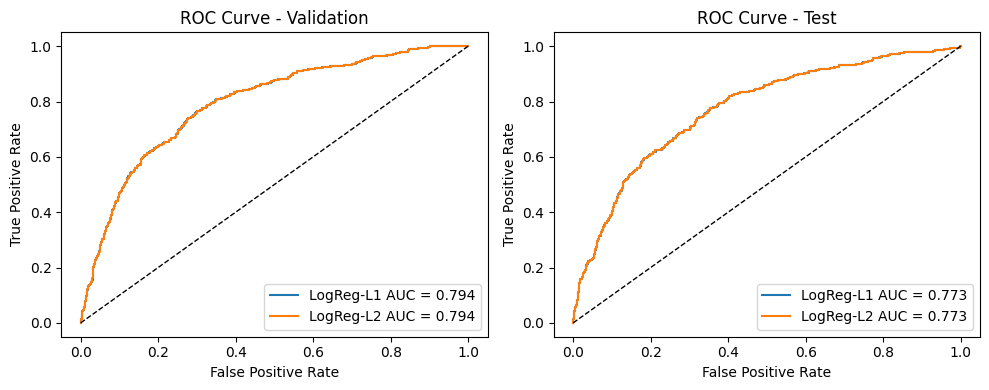

In [13]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
dataset_order = ['Validation', 'Test']
for ax, dataset_name in zip(axes, dataset_order):
    for penalty, label in model_labels.items():
        roc_info = curve_data[penalty][dataset_name]
        ax.plot(roc_info['fpr'], roc_info['tpr'], label=f"{label} AUC = {roc_info['auc']:.3f}")
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {dataset_name}')
    ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig(FIG_DIR / 'roc_curve_logreg_l1_l2.png', dpi=200)
plt.show()


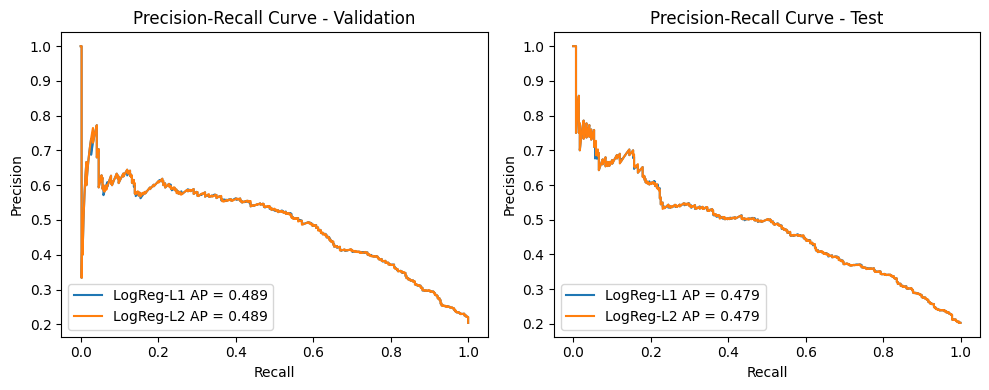

In [14]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, dataset_name in zip(axes, dataset_order):
    for penalty, label in model_labels.items():
        pr_info = curve_data[penalty][dataset_name]
        ax.plot(pr_info['recall'], pr_info['precision'], label=f"{label} AP = {pr_info['ap']:.3f}")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve - {dataset_name}')
    ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig(FIG_DIR / 'pr_curve_logreg_l1_l2.png', dpi=200)
plt.show()


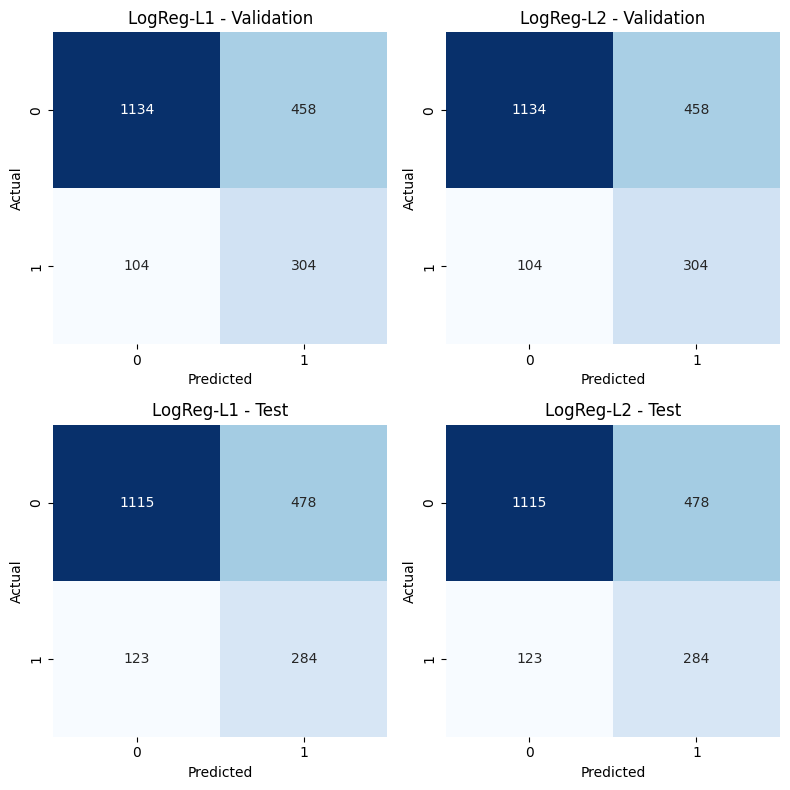

In [15]:

fig, axes = plt.subplots(2, len(model_labels), figsize=(4 * len(model_labels), 8))
dataset_order = ['Validation', 'Test']
for col, (penalty, label) in enumerate(model_labels.items()):
    for row, dataset_name in enumerate(dataset_order):
        ax = axes[row, col]
        sns.heatmap(conf_matrices[penalty][dataset_name], annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f"{label} - {dataset_name}")
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrices_logreg_l1_l2.png', dpi=200)
plt.show()


### Step 8: Inspect Coefficients

In [16]:

feature_names = log_reg_models['l2'].named_steps['preprocess'].get_feature_names_out()
coef_frames = []
for penalty, label in model_labels.items():
    coef = log_reg_models[penalty].named_steps['model'].coef_[0]
    coef_frames.append(pd.Series(coef, index=feature_names, name=label))
coef_df = pd.concat(coef_frames, axis=1)
coef_df['MaxAbs'] = coef_df.abs().max(axis=1)
coef_df.sort_values('MaxAbs', ascending=False).head(15)


,LogReg-L1,LogReg-L2,MaxAbs
numeric__Age,0.791541,0.792098,0.792098
categorical__Geography_Germany,0.570010,0.466788,0.570010
categorical__Gender_Male,-0.494957,-0.295631,0.494957
numeric__IsActiveMember,-0.426517,-0.427306,0.427306
categorical__Geography_France,-0.193581,-0.299704,0.299704
categorical__Geography_Spain,-0.154829,-0.262320,0.262320
categorical__Gender_Female,0.000000,0.200395,0.200395
numeric__Balance,0.178894,0.179055,0.179055
numeric__CreditScore,-0.109839,-0.110653,0.110653
numeric__EstimatedSalary,0.043325,0.044127,0.044127


### Step 9: Persist Model

In [17]:

MODEL_DIR = Path('models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
model_paths = {}
for penalty, pipeline in log_reg_models.items():
    model_path = MODEL_DIR / f'log_reg_{penalty}_baseline.joblib'
    joblib.dump(pipeline, model_path)
    model_paths[model_labels[penalty]] = model_path
model_paths


{'LogReg-L1': PosixPath('models/log_reg_l1_baseline.joblib'),
 'LogReg-L2': PosixPath('models/log_reg_l2_baseline.joblib')}